In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/ULTS/UNET')

In [2]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar
import tensorflow as tf

from tqdm import tqdm_notebook as tqdm #, tnrange
#from itertools import chain
from skimage.io import imread, imshow

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
import matplotlib.pyplot as plt

from imgaug import augmenters as iaa

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

Using TensorFlow backend.


In [5]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'



warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

print("Imported all the dependencies")

Imported all the dependencies


In [0]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print("X_train",X_train.shape)
print("Y_train",Y_train.shape)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/image/' + id_ + '.jpg')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/mask/'))[2]:
        mask_ = imread(path + '/mask/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

X_train (177, 256, 256, 3)
Y_train (177, 256, 256, 1)
Getting and resizing train images and masks ... 


In [0]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")
print('Getting and resizing test images and masks ... ')
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/image/' + id_ + '.jpg')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/mask/'))[2]:
        mask_ = imread(path + '/mask/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_test[n] = mask
print('Done!')

X_test shape: (22, 256, 256, 3)
Y_test shape: (22, 256, 256, 1)
Getting and resizing test images and masks ... 
Getting and resizing test images ... 


Done!


In [0]:
X_train = np.append(X_train, [np.fliplr(x) for x in tqdm(X_train)], axis=0)
Y_train = np.append(Y_train, [np.fliplr(x) for x in tqdm(Y_train)], axis=0)

In [0]:
X_test = np.append(X_test, [np.fliplr(x) for x in tqdm(X_test)], axis=0)
Y_test = np.append(Y_test, [np.fliplr(x) for x in tqdm(Y_test)], axis=0)

In [0]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")

Shape of X_train: (354, 256, 256, 3)
Shape of Y_train: (354, 256, 256, 1)


In [0]:
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

Shape of X_test: (44, 256, 256, 3)
Shape of Y_test: (44, 256, 256, 1)


In [0]:
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=[dice_coef,mean_iou])
    return model

In [6]:
# get u_net model
u_net = get_unet()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.








In [0]:
# serialize model to JSON
model_json = u_net.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
u_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [0]:
# fit model on train_data
from keras.callbacks import EarlyStopping, ModelCheckpoint
print("\nTraining...")
# epochs = 50
# checkpointer = ModelCheckpoint('model-unet.h5', verbose=1, save_best_only=True,monitor='mean_iou',mode='max',save_weights_only=True)
# results = u_net.fit(img_total,mask_total,batch_size=16,epochs=epochs,callbacks=[checkpointer])


checkpointer = ModelCheckpoint('model-unet-feb.h5', verbose=1, save_best_only=False)
results = u_net.fit(X_train, Y_train, validation_data=[X_test,Y_test], batch_size=16, epochs=100,callbacks=[checkpointer])


Training...


Train on 354 samples, validate on 44 samples
Epoch 1/100
354/354 [==============================] - 13s 36ms/step - loss: 0.4900 - dice_coef: 0.2241 - mean_iou: 0.3918 - val_loss: 0.3174 - val_dice_coef: 0.1791 - val_mean_iou: 0.4244

Epoch 00001: saving model to model-unet-feb.h5
Epoch 2/100
354/354 [==============================] - 3s 8ms/step - loss: 0.3735 - dice_coef: 0.5190 - mean_iou: 0.4424 - val_loss: 0.3295 - val_dice_coef: 0.2780 - val_mean_iou: 0.4590

Epoch 00002: saving model to model-unet-feb.h5
Epoch 3/100
354/354 [==============================] - 3s 8ms/step - loss: 0.3459 - dice_coef: 0.5723 - mean_iou: 0.4700 - val_loss: 0.2269 - val_dice_coef: 0.6034 - val_mean_iou: 0.4816

Epoch 00003: saving model to model-unet-feb.h5
Epoch 4/100
354/354 [==============================] - 3s 8ms/step - loss: 0.3242 - dice_coef: 0.6026 - mean_iou: 0.4885 - val_loss: 0.2047 - val_dice_coef: 0.7066 - val_mean_iou: 0.4951

Epoch 00004: saving model to model-unet-feb.h

# Prediction

In [10]:
#Predict on train, val and test
model = load_model('model-unet-feb.h5', custom_objects={'mean_iou': mean_iou, 'dice_coef': dice_coef})

In [0]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

44/44 [==============================] - 0s 2ms/step


In [0]:

preds_train_t = (preds_train > 0.5)
preds_val_t = (preds_val > 0.5)
preds_test_t = (preds_test > 0.5)

4


<Figure size 432x288 with 0 Axes>

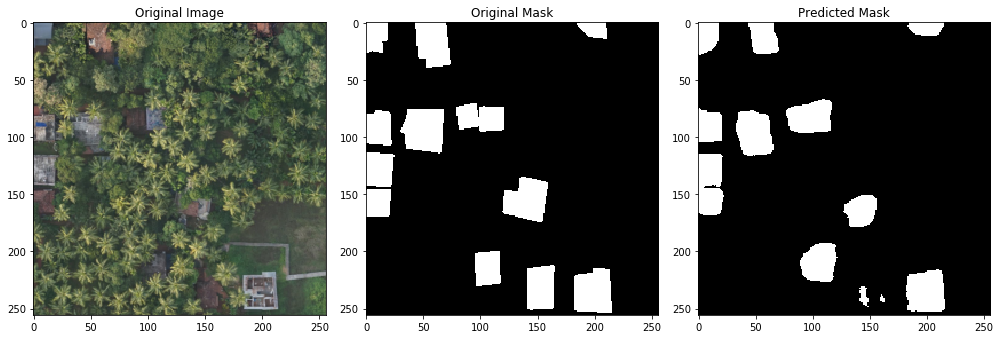

In [0]:
test_img = 4
def pred_img(test_img):
    print(f"{test_img}")
    plt.figure(1)
    plt.figure(figsize=(14,14))
    plt.subplot(131)
    plt.title("Original Image")
    imshow(X_test[test_img])
    plt.subplot(132)
    plt.title("Original Mask")
    imshow(np.squeeze(Y_test[test_img]))
    plt.subplot(133)
    plt.title("Predicted Mask")
    imshow(np.squeeze(preds_test_t[test_img]))
    plt.show()
pred_img(test_img)

In [0]:
import json
import numpy as np
from pycocotools import mask
from skimage import measure
import matplotlib.pyplot as plt
import cv2

In [0]:
np.squeeze(preds_test_t[4]).shape

(256, 256)

In [0]:
ground_image = X_test[4].copy()
ground_mask = np.squeeze(preds_test_t[4])

In [0]:
def plot_annotation(ground_image,ground_mask):

        ground_mask = ground_mask.astype('uint8')

        fortran_ground_truth_binary_mask = np.asfortranarray(ground_mask)
        encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
        ground_truth_area = mask.area(encoded_ground_truth)
        ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)

        contours = measure.find_contours(ground_mask, 0.5)


        annotation = {
                "segmentation": [],
                "image_id": 123,
                "bbox": ground_truth_bounding_box.tolist(),
                "category_id": 1,
                "id": 1
            }


        for contour in contours:
            contour = np.flip(contour, axis=1)
            segmentation = contour.ravel().tolist()
            annotation["segmentation"].append(segmentation)


        coords = annotation['segmentation']
        coord_list = []
        for c in coords:
          c_list = [[[c[i],c[i+1]]] for i in range(0,len(c),2)]
          c_arr =  np.array(c_list,dtype='int32')
          coord_list.append(c_arr)

        for draw in coord_list:
            cv2.drawContours(ground_image, [draw], 0, (0,255,0), 1)


        # plt.figure(figsize=(20,10))
        plt.imshow(ground_image)



7


<Figure size 432x288 with 0 Axes>

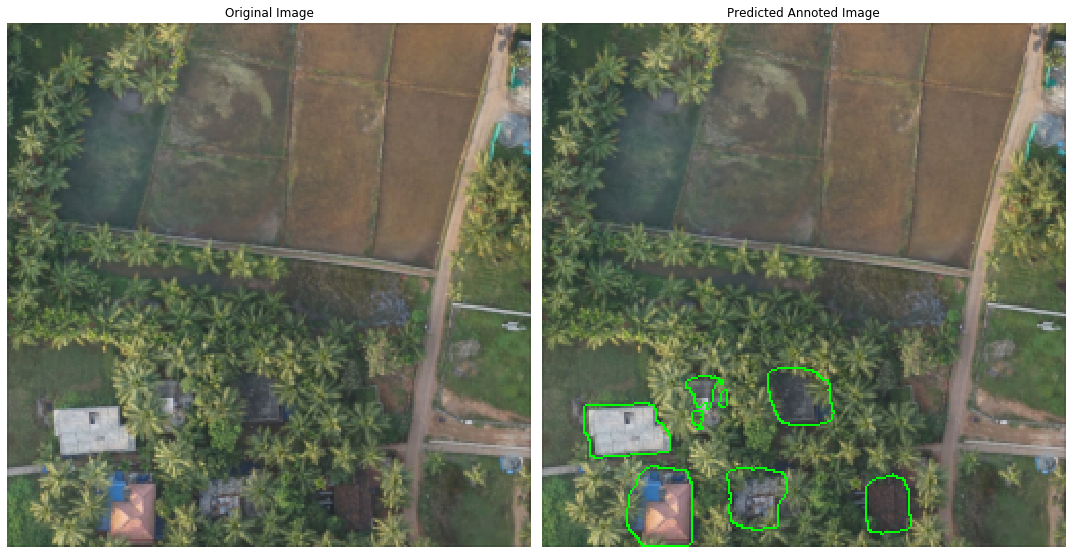

In [0]:
def pred_annot(test_img):
    print(f"{test_img}")
    plt.figure(1)
    plt.figure(figsize=(15,14))
    plt.subplot(121)
    plt.title("Original Image")
    plt.axis('off')
    imshow(X_test[test_img])
    plt.subplot(122)
    plt.axis('off')
    plt.title("Predicted Annoted Image")
    ground_image = X_test[test_img].copy()
    plot_annotation(ground_image,np.squeeze(preds_test_t[test_img]))
    plt.show()

pred_annot(7)

2


<Figure size 432x288 with 0 Axes>

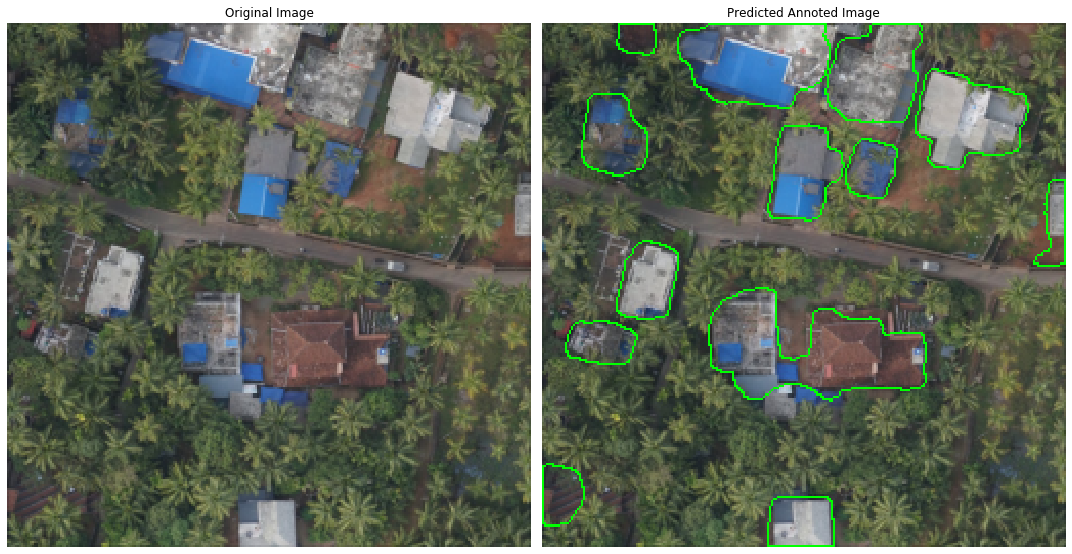

In [0]:
pred_annot(2)

14


<Figure size 432x288 with 0 Axes>

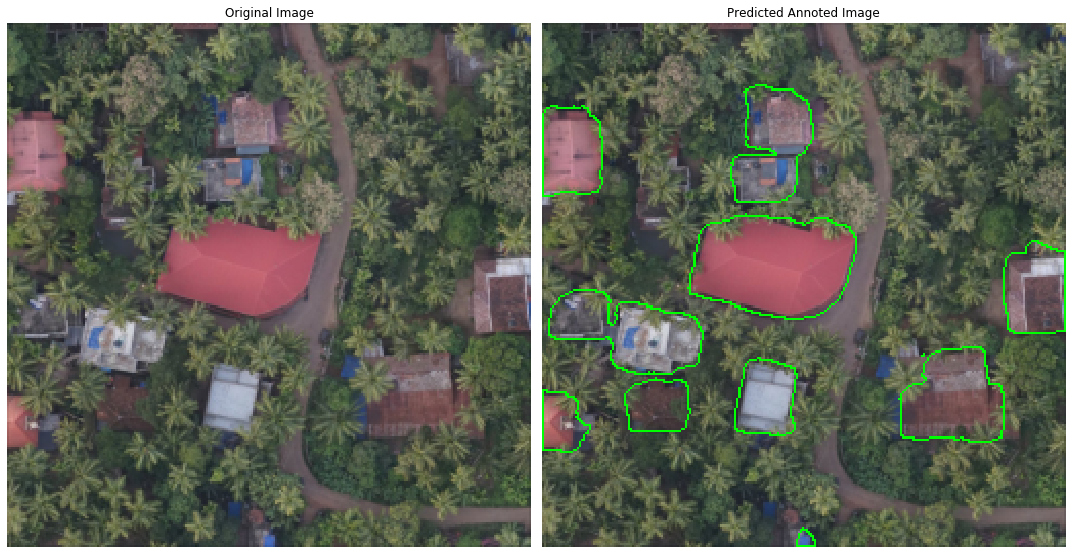

In [0]:
pred_annot(14)